# Semantic Segmentation

**Segmentation** is one of the main computer vision task. For **each** pixel of image you must specify class(background included). Semantic segmentation only tells pixel class, instance segmentation divide classes into different instances. 

For instance segmentation ten cars is **different** objects, for semantic segmentation **all** cars is one class.

<img src="images/instance_vs_semantic.jpeg" width="50%">

> Image from [this blog post](https://nirmalamurali.medium.com/image-classification-vs-semantic-segmentation-vs-instance-segmentation-625c33a08d50)

Almost all architectures have same structure. First part is **encoder** that extracts features from input image, second part is **decoder** that transforms this features into image with same height and width and some number of channels, may be equal to classes count.

<img src="images/segm.png" width="50%">

> Image from [this publication](https://arxiv.org/pdf/2001.05566.pdf)

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from skimage.io import imread
from skimage.transform import resize
import os
torch.manual_seed(42)
np.random.seed(42)

In [12]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 0.9
lr = 1e-3
weight_decay = 1e-6
batch_size = 32
epochs = 30

## Dataset

In [ ]:
!apt-get install rar
!wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
!unrar x -Y PH2Dataset.rar

In [14]:
def load_dataset(train_part, root='PH2Dataset'):
    images = []
    masks = []

    for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
        if root.endswith('_Dermoscopic_Image'):
            images.append(imread(os.path.join(root, files[0])))
        if root.endswith('_lesion'):
            masks.append(imread(os.path.join(root, files[0])))

    size = (256, 256)
    images = torch.permute(torch.FloatTensor([resize(image, size, mode='constant', anti_aliasing=True,) for image in images]), (0, 3, 1, 2))
    masks = torch.FloatTensor([resize(mask, size, mode='constant', anti_aliasing=False) > 0.5 for mask in masks]).unsqueeze(1)

    indices = np.random.permutation(range(len(images)))
    train_part = int(train_part * len(images))
    train_ind = indices[:train_part]
    test_ind = indices[train_part:]

    train_dataset = (images[train_ind, :, :, :], masks[train_ind, :, :, :])
    test_dataset = (images[test_ind, :, :, :], masks[test_ind, :, :, :])

    return train_dataset, test_dataset

In [15]:
train_dataset, test_dataset = load_dataset(train_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':


In [16]:
train_dataloader = torch.utils.data.DataLoader(list(zip(train_dataset[0], train_dataset[1])), batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(list(zip(test_dataset[0], test_dataset[1])), batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

In [17]:
def plotn(n, data, only_mask=False):
    images, masks = data[0], data[1]
    fig, ax = plt.subplots(1, n)
    fig1, ax1 = plt.subplots(1, n)
    for i, (img, mask) in enumerate(zip(images, masks)):
        if i == n:
            break
        if not only_mask:
            ax[i].imshow(torch.permute(img, (1, 2, 0)))
        else:
            ax[i].imshow(img[0])
        ax1[i].imshow(mask[0])
    plt.show()

**Let's plot some images with corresponding masks.**

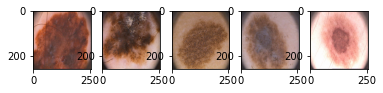

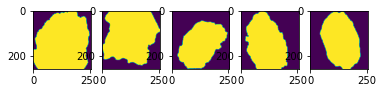

In [18]:
plotn(5, train_dataset)

## SegNet

Simple encoder - decoder architecture with convolutions, poolings in encoder and convolutions, upsamplings in decoder.

<img src="images/segnet.png" width="50%">

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.act0 = nn.ReLU()
        self.bn0 = nn.BatchNorm2d(16)
        self.pool0 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 =  nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 =  nn.MaxPool2d(kernel_size=(2,2))

        self.bottleneck_conv = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1)
        
        self.upsample0 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv0 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3), padding=1)
        self.dec_act0 = nn.ReLU()
        self.dec_bn0 = nn.BatchNorm2d(128)

        self.upsample1 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv1 =  nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3), padding=1)
        self.dec_act1 = nn.ReLU()
        self.dec_bn1 = nn.BatchNorm2d(64)

        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)
        
        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), padding=1)
        self.dec_act2 = nn.ReLU()
        self.dec_bn2 = nn.BatchNorm2d(32)

        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(1,1))

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e0 = self.pool0(self.bn0(self.act0(self.enc_conv0(x))))
        e1 = self.pool1(self.bn1(self.act1(self.enc_conv1(e0))))
        e2 = self.pool2(self.bn2(self.act2(self.enc_conv2(e1))))
        e3 = self.pool3(self.bn3(self.act3(self.enc_conv3(e2))))

        b = self.bottleneck_conv(e3)

        d0 = self.dec_bn0(self.dec_act0(self.dec_conv0(self.upsample0(b))))
        d1 = self.dec_bn1(self.dec_act1(self.dec_conv1(self.upsample1(d0))))
        d2 = self.dec_bn2(self.dec_act2(self.dec_conv2(self.upsample2(d1))))
        d3 = self.sigmoid(self.dec_conv3(self.upsample3(d2)))
        return d3

In [ ]:
model = SegNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss()

In [21]:
def train(dataloaders, model, loss_fn, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            preds = model(imgs)
            loss = loss_fn(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.to(device)
                labels = labels.to(device)

                preds = model(imgs)
                loss = loss_fn(preds, labels)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [ ]:
train(dataloaders, model, loss_fn, optimizer, epochs, device)

100%|██████████| 30/30 [01:11<00:00,  2.38s/it, train loss:=0.601, test loss:=0.62]


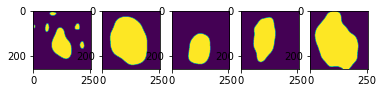

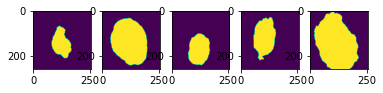

In [ ]:
model.eval()
predictions = []
image_mask = []
plots = 5
images, masks = test_dataset[0], test_dataset[1]
for i, (img, mask) in enumerate(zip(images, masks)):
    if i == plots:
        break
    img = img.to(device).unsqueeze(0)
    predictions.append((model(img).detach().cpu()[0] > 0.5).float())
    image_mask.append(mask)
plotn(plots, (predictions, image_mask), only_mask=True)

## U-Net

Very simple architecture that used skip connections. Skip connections at each convolution level helps network doesn't lost information about features from original input at this level.

U-Net usually has a default encoder for feature extraction, for example resnet50.

<img src="images/unet.png" width="50%">

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. [U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.act0 = nn.ReLU()
        self.bn0 = nn.BatchNorm2d(16)
        self.pool0 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 =  nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 =  nn.MaxPool2d(kernel_size=(2,2))

        self.bottleneck_conv = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1)
        
        self.upsample0 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv0 = nn.Conv2d(in_channels=384, out_channels=128, kernel_size=(3,3), padding=1)
        self.dec_act0 = nn.ReLU()
        self.dec_bn0 = nn.BatchNorm2d(128)

        self.upsample1 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv1 =  nn.Conv2d(in_channels=192, out_channels=64, kernel_size=(3,3), padding=1)
        self.dec_act1 = nn.ReLU()
        self.dec_bn1 = nn.BatchNorm2d(64)

        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv2 = nn.Conv2d(in_channels=96, out_channels=32, kernel_size=(3,3), padding=1)
        self.dec_act2 = nn.ReLU()
        self.dec_bn2 = nn.BatchNorm2d(32)

        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv3 = nn.Conv2d(in_channels=48, out_channels=1, kernel_size=(1,1))

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e0 = self.pool0(self.bn0(self.act0(self.enc_conv0(x))))
        e1 = self.pool1(self.bn1(self.act1(self.enc_conv1(e0))))
        e2 = self.pool2(self.bn2(self.act2(self.enc_conv2(e1))))
        e3 = self.pool3(self.bn3(self.act3(self.enc_conv3(e2))))

        cat0 = self.bn0(self.act0(self.enc_conv0(x)))
        cat1 = self.bn1(self.act1(self.enc_conv1(e0)))
        cat2 = self.bn2(self.act2(self.enc_conv2(e1)))
        cat3 = self.bn3(self.act3(self.enc_conv3(e2)))

        b = self.bottleneck_conv(e3)

        d0 = self.dec_bn0(self.dec_act0(self.dec_conv0(torch.cat((self.upsample0(b), cat3), dim=1))))
        d1 = self.dec_bn1(self.dec_act1(self.dec_conv1(torch.cat((self.upsample1(d0), cat2), dim=1))))
        d2 = self.dec_bn2(self.dec_act2(self.dec_conv2(torch.cat((self.upsample2(d1), cat1), dim=1))))
        d3 = self.sigmoid(self.dec_conv3(torch.cat((self.upsample3(d2), cat0), dim=1)))
        return d3

In [ ]:
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
train(dataloaders, model, loss_fn, optimizer, epochs, device)

100%|██████████| 30/30 [01:45<00:00,  3.52s/it, train loss:=0.6, test loss:=0.609]


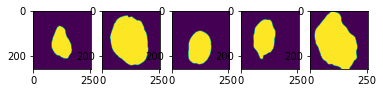

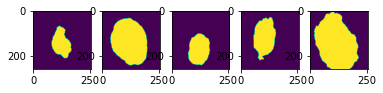

In [ ]:
model.eval()
predictions = []
image_mask = []
plots = 5
images, masks = test_dataset[0], test_dataset[1]
for i, (img, mask) in enumerate(zip(images, masks)):
    if i == plots:
        break
    img = img.to(device).unsqueeze(0)
    predictions.append((model(img).detach().cpu()[0] > 0.5).float())
    image_mask.append(mask)
plotn(plots, (predictions, image_mask), only_mask=True)